## **End to end Multi-class Dog Breed Classification**

This notebook builds an end-to-end multi-class image classifier using Tensorflow.

### 1. Problem 

Identifying the breed of any dog from an image
### 2. Data

Data is being used from the Kaggle Dog Breed Identification competition : https://www.kaggle.com/c/dog-breed-identification/data
### 3. Evaluation

The evaluation is a file with predicted probabilities for each dog breed of each test image
### 4. Features

* We are dealing with unstructured data
* There are 120 different dog breeds 
* There are 10,000+ images in test and training set.


In [61]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras

In [62]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
print('Tensorflow Keras version:', tf.keras.__version__)
!nvcc --version
print("TensorFlow CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("TensorFlow cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])

TensorFlow version: 2.18.0
TensorFlow Hub version: 0.16.1
Tensorflow Keras version: 3.8.0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0
TensorFlow CUDA Version: 12.5.1
TensorFlow cuDNN Version: 9


In [63]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
print("Detailed Device Information:")
for device in devices:
    print(f"Name: {device.name}, Type: {device.device_type}, Description: {device.physical_device_desc}")

Detailed Device Information:
Name: /device:CPU:0, Type: CPU, Description: 
Name: /device:GPU:0, Type: GPU, Description: device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1737145341.382306    6011 gpu_device.cc:2022] Created device /device:GPU:0 with 9426 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [64]:
import tensorflow_hub as tub

**Turning all of our data into tensors (numerical representation for unstructured data)**

In [65]:
import pandas as pd

In [66]:
labels_csv =pd.read_csv('/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/labels.csv')
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [67]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126

<Axes: xlabel='breed'>

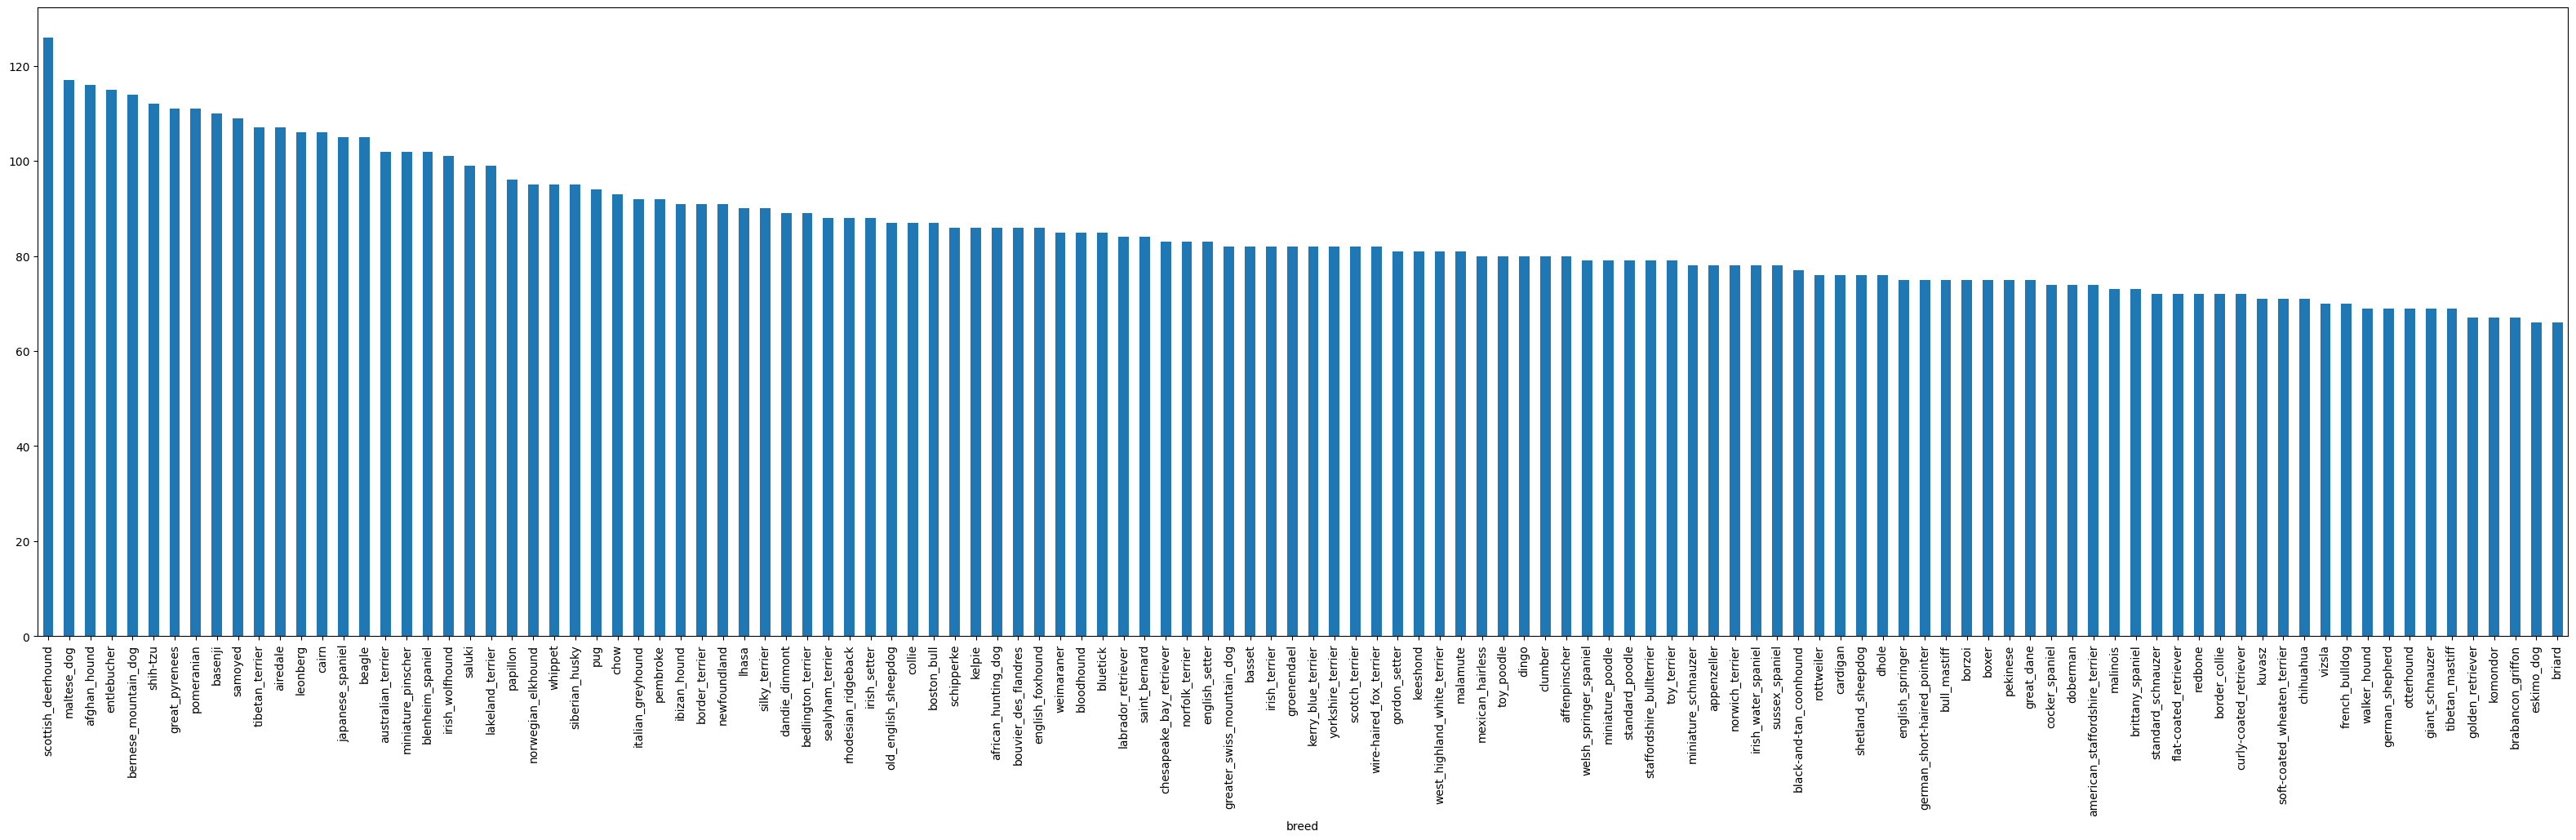

In [68]:
labels_csv['breed'].value_counts().plot.bar(figsize = (40,10))

In [69]:
labels_csv['breed'].value_counts().median()

np.float64(82.0)

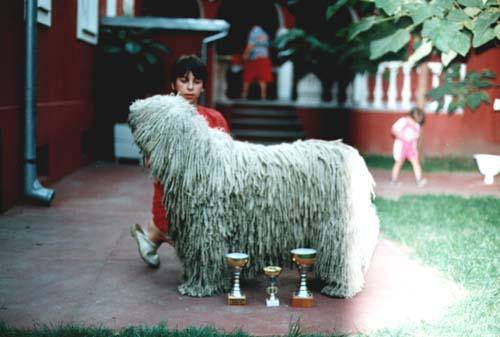

In [70]:
from IPython.display import Image
Image("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/0a001d75def0b4352ebde8d07c0850ae.jpg")


#### **Getting a list of all image file pathnames**

In [71]:
filenames = ["/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/"+fname+".jpg" for fname in labels_csv['id']]
filenames[:10]

['/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-br

In [72]:
import os
if len(os.listdir("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/train/")) == len(filenames):
    print("Matching")
else:
    print("There is a mistake")

Matching


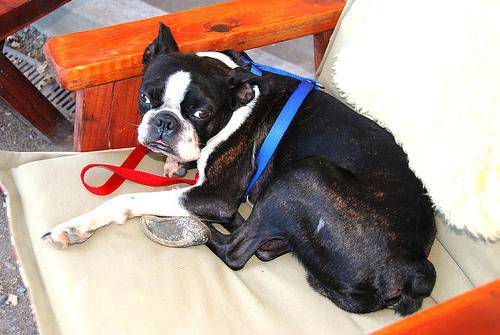

In [73]:
Image(filenames[4040])

In [74]:
labels_csv.iloc[4040]

id       6487f0f5886fa4e46ef422d8069acb8d
breed                                 pug
Name: 4040, dtype: object

#### **Let's prepare our labels**

In [75]:
import numpy as np

In [76]:
labels = labels_csv['breed'].to_numpy()

In [77]:
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [78]:
if len(labels) == len(filenames) :  
    print("No issues")
else:
    print("Number of labels does not match number of file names")

No issues


In [79]:
unique_breeds = np.unique(labels)

In [80]:
len(unique_breeds)

120

#### **Turn every label into a boolean array**

In [81]:
print(labels[0])
labels[0] == unique_breeds   #Returns a boolean array where only the location where the given label is present is as True and every other one is as false.

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [82]:
boolean_labels = [label == unique_breeds for label in labels]

In [83]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [84]:
len(boolean_labels)

10222

In [85]:
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))


19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


#### **Creating our own validation set**

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X = filenames
y = boolean_labels

We're going to start off with experimenting with 1000 images and increase as needed.

In [88]:
NUM_IMAGES = 8000
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2,random_state=42)

In [89]:
len(X_train),len( X_val), len(y_train), len(y_val)

(6400, 1600, 6400, 1600)

#### **Preprocessing Images (Turning Images into Tensors)**

We will create a function to do so:
1. Take Image Filepath as input
2. Use Tensorflow to read the file and save it to a variable 'image' 
3. Turn out 'image' a '.jpg' into a Tensor
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the 'image' to be a shape of (224,224)
6. Return the modified 'image'

In [90]:
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [91]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [92]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [93]:
# Define Image Size
IMG_SIZE = 224

def process_image(image_path, img_size = IMG_SIZE):
    """
    Take an image file path and turn that image into a Tensor so that it can run on the GPU

    Args:
        image_path (string): the path of the image to be converted 
    """

    image = tf.io.read_file(image_path)
    # Turn the jpeg image into a numerical tensor with 3 color channels
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resizing the image 
    image = tf.image.resize(image, size = (IMG_SIZE,IMG_SIZE))

    return image

#### **Turning out data into batches**

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of process_image function at the same time.

In [94]:
def get_image_label(image_path, label):
    """
    Takes an image file path and the associated label and
    processes the image and returns it as a tuple in the form
    (image, label)
    """ 
    image = process_image(image_path)
    return image, label

In [95]:
(process_image(X[42]), y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

#### **Defining a fucntioon to turn all of the data into batches**

In [96]:
# Define the batch size, default to 32
BATCH_SIZE = 32

def create_data_batches(X, y  = None, batch_size = BATCH_SIZE, val_data = False, test_data = False):
    if test_data:
        print("Creating Test Data Batches: ")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    elif val_data: 
        print("Creating Validation Data Batches: ")
        data =tf.data.Dataset.from_tensor_slices((tf.constant(X), # Filepaths
                                                 tf.constant(y))) #Labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating Training Data Batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
                                                   tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
        return data_batch

In [97]:
train_data = create_data_batches(X_train,y_train)

Creating Training Data Batches


In [98]:
val_data = create_data_batches(X_val, y_val, val_data=True)
    

Creating Validation Data Batches: 


In [99]:
# Checking Different Attributes of data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [100]:
tf.__version__

'2.18.0'

#### **Visualizing Data Batches**

In [101]:
import matplotlib.pyplot as plt

In [102]:
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch
    """

    plt.figure(figsize=(15,15))
    for i in range(25):
        ax=plt.subplot(5,5, i+1)    

        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

In [103]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.4648197 , 0.598153  , 0.36135334],
          [0.6057774 , 0.72401965, 0.5171219 ],
          [0.6746543 , 0.77990645, 0.60481447],
          ...,
          [0.77457774, 0.8644587 , 0.6981772 ],
          [0.7864847 , 0.8543769 , 0.71696   ],
          [0.8121151 , 0.8800072 , 0.7471641 ]],
 
         [[0.52417284, 0.65750617, 0.42070642],
          [0.61707807, 0.7353204 , 0.52842265],
          [0.66221774, 0.7674699 , 0.59194463],
          ...,
          [0.70559585, 0.79547685, 0.6291954 ],
          [0.7283964 , 0.80633765, 0.6146446 ],
          [0.74765426, 0.82559544, 0.6214287 ]],
 
         [[0.57653624, 0.7098696 , 0.47391677],
          [0.6658264 , 0.7840687 , 0.5771709 ],
          [0.6484594 , 0.7576331 , 0.57034314],
          ...,
          [0.72487104, 0.8117758 , 0.65599865],
          [0.7509302 , 0.8292872 , 0.6226189 ],
          [0.7610646 , 0.83900577, 0.61772364]],
 
         ...,
 
         [[0.8198245 , 0.82039136, 0.5885439 ],
          [0.80116

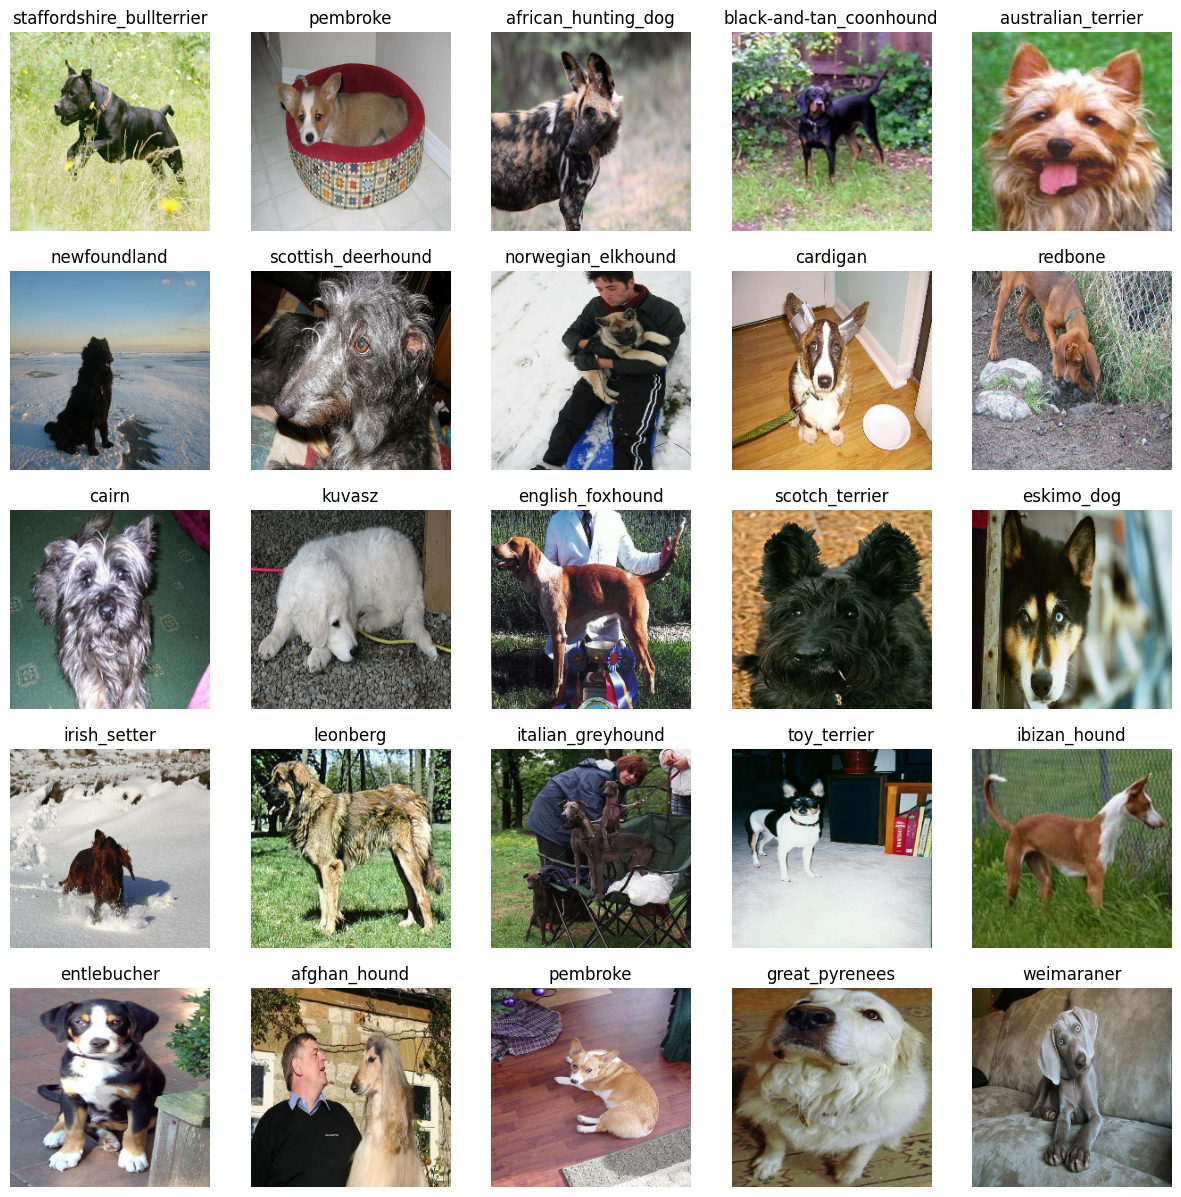

In [104]:
show_25_images(train_images, train_labels)

In [105]:
val_images, val_labels = next(val_data.as_numpy_iterator())
val_images, val_labels

(array([[[[0.15895234, 0.27919042, 0.29946354],
          [0.1586222 , 0.2788603 , 0.2991334 ],
          [0.12764731, 0.24788542, 0.26815853],
          ...,
          [0.11045246, 0.21000847, 0.11500288],
          [0.2088826 , 0.32715216, 0.23898697],
          [0.2447379 , 0.36968663, 0.28826034]],
 
         [[0.11330783, 0.21905014, 0.24457535],
          [0.13480018, 0.24054249, 0.2660677 ],
          [0.17234644, 0.27808875, 0.30361396],
          ...,
          [0.12183501, 0.19028737, 0.11406183],
          [0.10786715, 0.18818286, 0.1157964 ],
          [0.21178885, 0.30047935, 0.23556337]],
 
         [[0.13823655, 0.22356445, 0.2563613 ],
          [0.11416067, 0.1973502 , 0.23085986],
          [0.12530887, 0.20707284, 0.24105768],
          ...,
          [0.19343889, 0.20796967, 0.15427186],
          [0.1321086 , 0.16008459, 0.11113255],
          [0.19524464, 0.22544922, 0.18408643]],
 
         ...,
 
         [[0.34701487, 0.43613678, 0.38585797],
          [0.37719

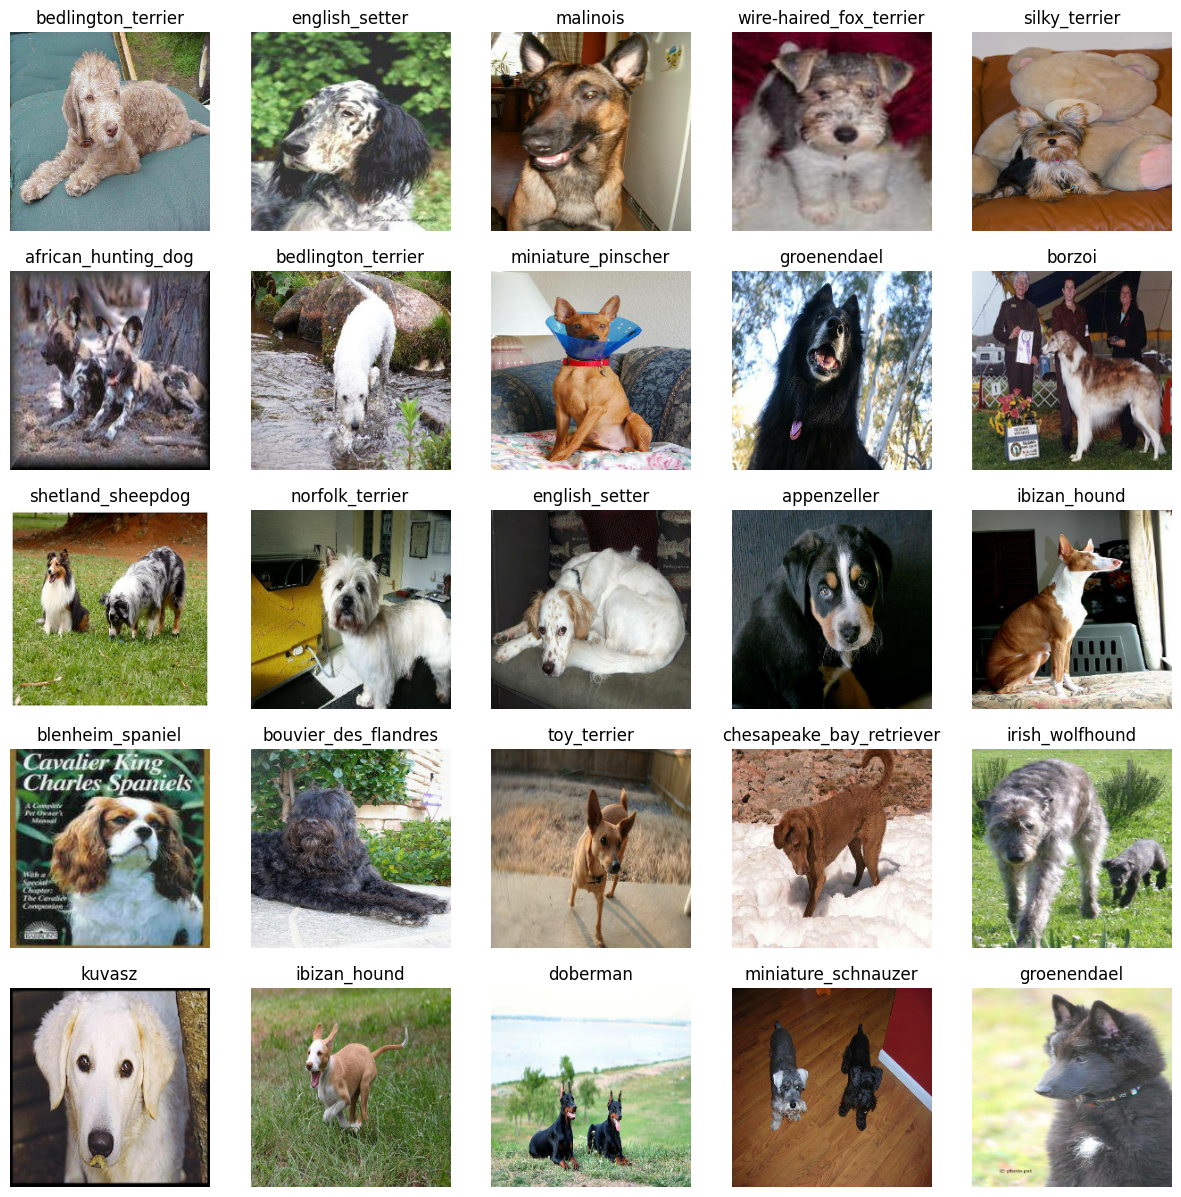

In [106]:
show_25_images(val_images, val_labels)

### **Building a Model**

**Before building a model we need to define:**
1. The input shape (out image shape, in the form of tensors) to our model.
2. The output shape (image labels, in the form of tensors) to our model.
3. The URL of the model we want to use.

In [107]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #[batch, height, width, color channel] 

In [108]:
OUTPUT_SHAPE = len(unique_breeds)

In [109]:
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

#### **Lets create a function which:**
* Takes input shape, output shape and the model we have taken as a parameter
* Defines the layers in a Keras Model in sequential fasion 
* Compiles the model (says how it should be evaluated and improved)
* Builds the Model 
* Returns the model

In [110]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print("Building model with: ", MODEL_URL)
    
    model = keras.Sequential([
        hub.KerasLayer(MODEL_URL, trainable=False),
        keras.layers.Dense(OUTPUT_SHAPE,
                              activation = 'softmax')
    ])

    model.compile(
        loss = keras.losses.CategoricalCrossentropy(),
        optimizer  = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    model.build(INPUT_SHAPE)
    return model

In [111]:
model = create_model()

Building model with:  https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1


In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________



### Creating callbacks


**Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.**

**The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.**
TensorBoard Callbacks

TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:

1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize the our models training logs using the %tensorboard magic function (we'll do this later on).



In [113]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
import datetime

In [115]:
def create_tensorboard_callback():
    # Create a log directory for storing Tensorboard logs
    logdir = os.path.join("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/logs",
                          #Make it so that the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return keras.callbacks.TensorBoard(logdir)



### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [116]:
 # Create Early Stopping callback

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 3)

### Training our model (on our subset of data)
Our first model will only be trained on 1000 images to make sure everything is working.

In [117]:
NUM_EPOCHS = 100

In [118]:
def train_model():
    model = create_model()

    # Create new tensorboard session
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created

    model.fit(x= train_data, 
              epochs= NUM_EPOCHS,
              validation_data= val_data,
              callbacks = [tensorboard, early_stopping])
    
    return model

In [119]:
model = train_model()

Building model with:  https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Epoch 1/100
200/200 [==============================] - 6s 26ms/step - loss: 1.7319 - accuracy: 0.5961 - val_loss: 0.7954 - val_accuracy: 0.7775
Epoch 2/100
200/200 [==============================] - 5s 24ms/step - loss: 0.4358 - accuracy: 0.8775 - val_loss: 0.7123 - val_accuracy: 0.7931
Epoch 3/100
200/200 [==============================] - 5s 23ms/step - loss: 0.2364 - accuracy: 0.9448 - val_loss: 0.7214 - val_accuracy: 0.7862
Epoch 4/100
200/200 [==============================] - 5s 23ms/step - loss: 0.1445 - accuracy: 0.9730 - val_loss: 0.7118 - val_accuracy: 0.7850
Epoch 5/100
200/200 [==============================] - 5s 23ms/step - loss: 0.0958 - accuracy: 0.9864 - val_loss: 0.7253 - val_accuracy: 0.7881


In [120]:
%tensorboard --logdir /home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep\ Learning/Code/logs

## Making and Evaluating Predictions using a Trained Model

In [121]:
predictions = model.predict(val_data, verbose=1)

50/50 [==============================] - 1s 19ms/step


In [122]:
predictions

array([[4.6683194e-06, 7.6662827e-06, 3.3200735e-07, ..., 7.4667543e-05,
        8.5899867e-03, 4.3870932e-05],
       [4.4538519e-06, 8.7166689e-03, 1.4427314e-05, ..., 3.9071023e-05,
        5.2526843e-07, 1.3067194e-06],
       [6.5696383e-08, 2.8373952e-07, 4.1881249e-06, ..., 2.5381712e-07,
        4.3201118e-07, 3.8275965e-07],
       ...,
       [1.8620854e-07, 7.6399583e-06, 1.7612823e-06, ..., 3.7277052e-05,
        4.0269853e-04, 5.4781876e-06],
       [4.1694076e-07, 6.1426232e-07, 6.2933128e-07, ..., 5.8564478e-07,
        8.5764760e-03, 1.2991736e-06],
       [8.1956074e-05, 1.2006017e-05, 5.3731622e-08, ..., 2.3223777e-06,
        7.3373500e-05, 7.9218786e-05]], dtype=float32)

In [123]:
predictions.shape

(1600, 120)

In [124]:
np.sum(predictions[0])

np.float32(1.0000001)

In [125]:
index = 0
print(predictions[index])
print(f"the max value (probability) is: {np.max(predictions[index])}")
print(f"the sum value (probability) is: {np.sum(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")


[4.66831943e-06 7.66628273e-06 3.32007346e-07 3.44144506e-03
 1.02243905e-06 8.84966721e-06 1.57821443e-04 1.19864239e-06
 6.80243538e-05 1.62954966e-05 1.62617326e-01 7.67736674e-06
 5.40137517e-05 4.68673807e-06 8.33461229e-07 1.98285925e-04
 1.21640809e-07 8.33552840e-05 1.38477180e-05 4.36657501e-06
 2.23899060e-05 3.44405976e-07 4.78365564e-07 3.52907045e-05
 9.58676101e-05 1.26422094e-06 2.07634468e-04 4.30532481e-07
 5.68938267e-04 1.71195079e-05 1.03963558e-07 4.45248606e-03
 1.61594435e-04 1.96428155e-05 4.21042874e-04 4.40763572e-04
 2.64368714e-06 7.67491565e-06 5.78313632e-07 3.32750060e-05
 1.75604837e-05 2.80021450e-05 5.23426365e-07 6.46297576e-06
 1.45239062e-06 1.40253405e-06 2.18107942e-07 1.25862483e-04
 2.55604900e-05 6.44246829e-05 2.11945030e-06 4.59386484e-07
 7.07005120e-06 3.55418924e-05 6.76310606e-07 2.56987609e-04
 2.67269684e-07 1.41481636e-03 3.24290741e-05 1.28771737e-03
 6.51496666e-05 1.11890231e-05 6.66065489e-07 6.46700755e-06
 3.03798242e-06 7.855864

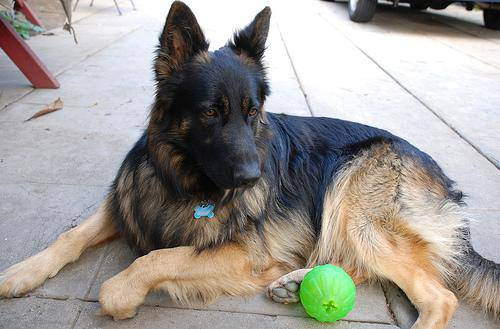

In [126]:
Image(filenames[np.argmax(predictions[index])])

In [127]:
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into its respective index

    """
    pred_index = np.argmax(prediction_probabilities)
    return unique_breeds[pred_index]

In [128]:
pred_label = get_pred_label(predictions[81])
pred_label

'doberman'

**Unbatching our validation dataset to make rpedictionsnon validation images and compare the predictions to the validation truth labels**

In [129]:
images_ = []
labels_ = []

for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

images_[0], labels_[0]

2025-01-18 01:52:53.739749: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.15895234, 0.27919042, 0.29946354],
         [0.1586222 , 0.2788603 , 0.2991334 ],
         [0.12764731, 0.24788542, 0.26815853],
         ...,
         [0.11045246, 0.21000847, 0.11500288],
         [0.2088826 , 0.32715216, 0.23898697],
         [0.2447379 , 0.36968663, 0.28826034]],
 
        [[0.11330783, 0.21905014, 0.24457535],
         [0.13480018, 0.24054249, 0.2660677 ],
         [0.17234644, 0.27808875, 0.30361396],
         ...,
         [0.12183501, 0.19028737, 0.11406183],
         [0.10786715, 0.18818286, 0.1157964 ],
         [0.21178885, 0.30047935, 0.23556337]],
 
        [[0.13823655, 0.22356445, 0.2563613 ],
         [0.11416067, 0.1973502 , 0.23085986],
         [0.12530887, 0.20707284, 0.24105768],
         ...,
         [0.19343889, 0.20796967, 0.15427186],
         [0.1321086 , 0.16008459, 0.11113255],
         [0.19524464, 0.22544922, 0.18408643]],
 
        ...,
 
        [[0.34701487, 0.43613678, 0.38585797],
         [0.37719962, 0.46616897, 0.45801

In [130]:
get_pred_label(predictions[0])

'lakeland_terrier'

In [131]:
get_pred_label(labels_[0])

'bedlington_terrier'

In [132]:
def unbatch_data(data):
    """
    Take the data in a batch and turn it into a unbatched numpy iterator

    """
    images =[]
    labels = []

    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    
    return images, labels

In [133]:
val_images, val_labels = unbatch_data(val_data)
val_images[0], val_labels[0]

2025-01-18 01:52:54.048285: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.15895234, 0.27919042, 0.29946354],
         [0.1586222 , 0.2788603 , 0.2991334 ],
         [0.12764731, 0.24788542, 0.26815853],
         ...,
         [0.11045246, 0.21000847, 0.11500288],
         [0.2088826 , 0.32715216, 0.23898697],
         [0.2447379 , 0.36968663, 0.28826034]],
 
        [[0.11330783, 0.21905014, 0.24457535],
         [0.13480018, 0.24054249, 0.2660677 ],
         [0.17234644, 0.27808875, 0.30361396],
         ...,
         [0.12183501, 0.19028737, 0.11406183],
         [0.10786715, 0.18818286, 0.1157964 ],
         [0.21178885, 0.30047935, 0.23556337]],
 
        [[0.13823655, 0.22356445, 0.2563613 ],
         [0.11416067, 0.1973502 , 0.23085986],
         [0.12530887, 0.20707284, 0.24105768],
         ...,
         [0.19343889, 0.20796967, 0.15427186],
         [0.1321086 , 0.16008459, 0.11113255],
         [0.19524464, 0.22544922, 0.18408643]],
 
        ...,
 
        [[0.34701487, 0.43613678, 0.38585797],
         [0.37719962, 0.46616897, 0.45801

In [134]:
def plot_pred(prediction_probabilities, labels, images,n=1):
    

    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    pred_label = get_pred_label(pred_prob)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.title("Predicted Label: {}  Prediction Probability: {:2.0f}%  True Label: {}".format(pred_label, np.max(pred_prob)*100,
                                      true_label),
                                      color = color)

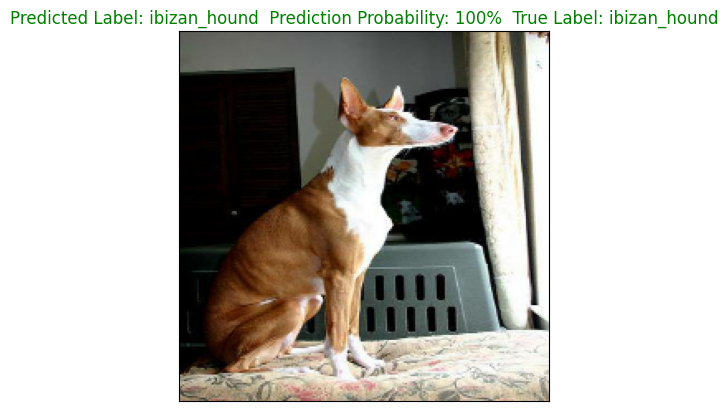

In [135]:
plot_pred(prediction_probabilities=predictions, labels = val_labels, images = val_images, n =14)

In [136]:
def plot_pred_conf(prediction_probabilities,labels, n=1):
    

    pred_prob, true_label = prediction_probabilities[n] , labels[n]

    pred_label = get_pred_label(pred_prob)

    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    top_10_pred_values = pred_prob[top_10_pred_indexes]

    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
       

    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                       top_10_pred_values,
                       color = 'grey')  
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation = "vertical")
    
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass

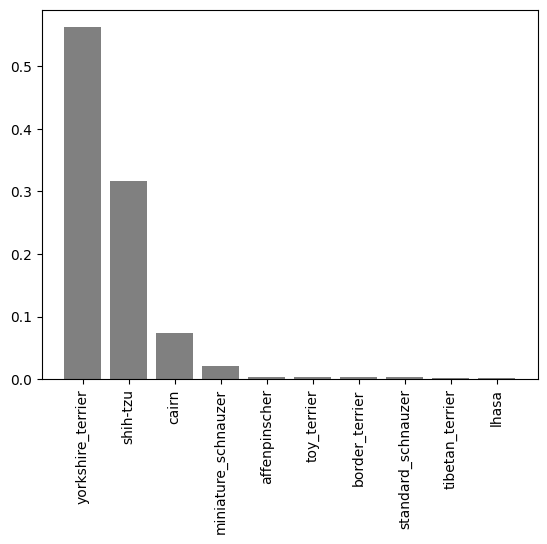

In [137]:
plot_pred_conf(prediction_probabilities=predictions,
               labels = val_labels,
               n = 4)

In [138]:
def save_model(model, suffix = None):
    modeldir = os.path.join("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models" , datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

    model_path = modeldir + "-" + suffix + ".h5"
    print("Saving model to: ", model_path)

    model.save(model_path)
    return model_path

In [139]:
def load_model(model_path):
    print("Loading saved model from: ", model_path)
    model = keras.models.load_model(model_path, custom_objects={"KerasLayer" : hub.KerasLayer})

    return model

In [140]:
save_model(model, suffix = "8000-images-mobilenetv2-Adam")

/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/.conda/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving model to:  /home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01521737145374-8000-images-mobilenetv2-Adam.h5


'/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01521737145374-8000-images-mobilenetv2-Adam.h5'

In [141]:
model2 = load_model("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250117-15281737107917-8000-images-mobilenetv2-Adam.h5")

Loading saved model from:  /home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250117-15281737107917-8000-images-mobilenetv2-Adam.h5


In [142]:
model2.evaluate(val_data)

50/50 [==============================] - 1s 20ms/step - loss: 0.8317 - accuracy: 0.7962


[0.8317145705223083, 0.7962499856948853]

In [143]:
model.evaluate(val_data)

50/50 [==============================] - 1s 20ms/step - loss: 0.7253 - accuracy: 0.7881


[0.7253144979476929, 0.7881249785423279]

# **Training on the Entire Dataset**

In [144]:
len(X), len(y)

(10222, 10222)

In [145]:
full_data = create_data_batches(X,y)

Creating Training Data Batches


In [146]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [147]:
full_model = create_model()

Building model with:  https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1


In [148]:
full_model_tensorboard =  create_tensorboard_callback()

In [149]:
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy", patience=4)

In [150]:
full_model.fit(x=full_data, epochs = 100, callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 8s 20ms/step - loss: 1.3513 - accuracy: 0.6649
Epoch 2/100
320/320 [==============================] - 6s 20ms/step - loss: 0.4096 - accuracy: 0.8796
Epoch 3/100
320/320 [==============================] - 6s 19ms/step - loss: 0.2371 - accuracy: 0.9349
Epoch 4/100
320/320 [==============================] - 6s 19ms/step - loss: 0.1574 - accuracy: 0.9617
Epoch 5/100
320/320 [==============================] - 7s 21ms/step - loss: 0.1069 - accuracy: 0.9792
Epoch 6/100
320/320 [==============================] - 6s 20ms/step - loss: 0.0783 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 6s 20ms/step - loss: 0.0585 - accuracy: 0.9920
Epoch 8/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0463 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 6s 19ms/step - loss: 0.0374 - accuracy: 0.9973
Epoch 10/100
320/320 [==============================] - 6s 19ms/step - loss: 0.030

In [151]:
save_model(full_model, suffix = "full-image-set-mobilenetv2-Adam")

Saving model to:  /home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01551737145504-full-image-set-mobilenetv2-Adam.h5


'/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01551737145504-full-image-set-mobilenetv2-Adam.h5'

In [162]:
loaded_full_model = load_model('/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01551737145504-full-image-set-mobilenetv2-Adam.h5')



Loading saved model from:  /home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/models/20250118-01551737145504-full-image-set-mobilenetv2-Adam.h5


## Making Predictions to the Test Data

**To Make predictions on test data**
1. We need to get test image filenames
2. Convert the filenames into test data batches using `create_data_batch()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
3. Make predictions array by passing the `predict()` method called on our model.

In [165]:
test_path = "/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:4]

['/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/test/62f97b18973de9c173cf3d1cb142baf2.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/test/d5c2ce713cfdb56cfbb9aac676aabbab.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/test/90d33610403888324897e8b126509704.jpg',
 '/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/dog-breed-identification/test/3ac0a45d49ce90e3dadd224adce11eaa.jpg']

In [166]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating Test Data Batches: 


In [167]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [168]:
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 6s 19ms/step


In [169]:
np.savetxt("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/preds_array.csv", test_predictions, delimiter=",")

In [170]:
test_predictions = np.loadtxt("/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/Deep Learning/Code/preds_array.csv", delimiter=",")

In [171]:
test_predictions[:10]

array([[2.16495843e-09, 1.37881488e-01, 7.84251136e-11, ...,
        2.07200437e-10, 8.26343705e-09, 7.71059149e-06],
       [2.85581177e-06, 1.20759491e-08, 1.16118422e-08, ...,
        2.62894542e-08, 2.05720426e-07, 1.74719077e-07],
       [3.74884877e-07, 1.09171978e-08, 3.33319483e-11, ...,
        1.10872522e-09, 9.82420811e-09, 7.42472110e-08],
       ...,
       [1.09292042e-08, 1.51495635e-10, 2.34094992e-12, ...,
        8.82614728e-12, 2.69507492e-08, 3.44350159e-10],
       [1.22789365e-13, 6.33020993e-14, 1.96282282e-10, ...,
        6.40534603e-09, 6.16025064e-10, 3.88891176e-11],
       [2.32722375e-09, 8.57432436e-09, 1.78114812e-09, ...,
        1.47643009e-08, 6.66207150e-12, 1.26066912e-09]])

In [172]:
test_predictions.shape

(10357, 120)